<a href="https://colab.research.google.com/github/JRcepeda/Proyectos/blob/main/Modelos_de_Clasificaci%C3%B3n_aplicado_a_negociaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
pip install ta #analisis técnico

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as mt
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [ ]:
datos=yf.Ticker('BTC-USD').history(start='2016-01-01',end='2021-01-01')
datos.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-01 00:00:00+00:00,430.721008,436.246002,427.515015,434.334015,36278900,0.0,0.0
2016-01-02 00:00:00+00:00,434.622009,436.062012,431.869995,433.437988,30096600,0.0,0.0
2016-01-03 00:00:00+00:00,433.578003,433.743011,424.705994,430.010986,39633800,0.0,0.0
2016-01-04 00:00:00+00:00,430.061005,434.516998,429.084015,433.091003,38477500,0.0,0.0
2016-01-05 00:00:00+00:00,433.069000,434.182007,429.675995,431.959991,34522600,0.0,0.0


# cálculo de indicadores técnicos

In [ ]:
#datos['MEXP5']=datos['Close'].ewm(span=5,adjust=False).mean()
#media movil exponencial
#se va a tomar decision comparando el precio actual con respecto a las medias

datos['MEXP 5']=ta.trend.ema_indicator(datos['Close'],5,True)/datos['Close']
datos['MEXP 20']=ta.trend.ema_indicator(datos['Close'],20,True)/datos['Close']
datos['MEXP 50']=ta.trend.ema_indicator(datos['Close'],50,True)/datos['Close']
datos['MEXP 100']=ta.trend.ema_indicator(datos['Close'],100,True)/datos['Close']

In [ ]:
#Ociladores
#indice de fuerza relativa : ocilador entre 0 y 100
datos['RSI']=ta.momentum.rsi(datos['Close'],fillna=True)

#rango verdadero medio: promedio de un determinado numero de peridos de las diferencias del precio mas alto y mas bajo del dia
datos['ATR']=ta.volatility.average_true_range(datos['High'],datos['Low'],datos['Close'],fillna=True)

#rango de porcentaje de williams
datos['WR']=ta.momentum.williams_r(datos['High'],datos['Low'],datos['Close'],fillna=True)

In [ ]:
datos.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MEXP 5,MEXP 20,MEXP 50,MEXP 100,RSI,ATR,WR
Date,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,430.721008,436.246002,427.515015,434.334015,36278900,0.0,0.0,1.000000,1.000000,1.000000,1.000000,100.000000,0.0,-21.898866
2016-01-02 00:00:00+00:00,434.622009,436.062012,431.869995,433.437988,30096600,0.0,0.0,1.001378,1.001870,1.001986,1.002026,0.000000,0.0,-32.161470
2016-01-03 00:00:00+00:00,433.578003,433.743011,424.705994,430.010986,39633800,0.0,0.0,1.006239,1.008916,1.009581,1.009814,0.000000,0.0,-54.029560
2016-01-04 00:00:00+00:00,430.061005,434.516998,429.084015,433.091003,38477500,0.0,0.0,0.999389,1.001575,1.002307,1.002580,43.782411,0.0,-27.339657
2016-01-05 00:00:00+00:00,433.069000,434.182007,429.675995,431.959991,34522600,0.0,0.0,1.001337,1.003798,1.004738,1.005102,37.320691,0.0,-37.140447


In [ ]:
datos['Close'].tail()

Date
2020-12-27 00:00:00+00:00    26272.294922
2020-12-28 00:00:00+00:00    27084.808594
2020-12-29 00:00:00+00:00    27362.437500
2020-12-30 00:00:00+00:00    28840.953125
2020-12-31 00:00:00+00:00    29001.720703
Name: Close, dtype: float64

In [ ]:
datos['Close'][-1]

29001.720703125

In [ ]:
#precio de cierre
r1=np.array(datos['Close'])
#el primero compara todos los dias siguientes con todos los dias actuales
target=np.where(r1[1:]>r1[:-1],1,-1)

In [ ]:
datos.drop(datos['Close'].index[-1],axis=0,inplace=True)#index[-1]

In [ ]:
datos['Variación_ p']=target

In [ ]:
datos.head()#la logica es: en el registro del dia t para la col variación se pondra 1 si para t+1 va a subir el precio o -1 si va a bajr

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MEXP 5,MEXP 20,MEXP 50,MEXP 100,RSI,ATR,WR,Variación_ p
Date,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,430.721008,436.246002,427.515015,434.334015,36278900,0.0,0.0,1.000000,1.000000,1.000000,1.000000,100.000000,0.0,-21.898866,-1
2016-01-02 00:00:00+00:00,434.622009,436.062012,431.869995,433.437988,30096600,0.0,0.0,1.001378,1.001870,1.001986,1.002026,0.000000,0.0,-32.161470,-1
2016-01-03 00:00:00+00:00,433.578003,433.743011,424.705994,430.010986,39633800,0.0,0.0,1.006239,1.008916,1.009581,1.009814,0.000000,0.0,-54.029560,1
2016-01-04 00:00:00+00:00,430.061005,434.516998,429.084015,433.091003,38477500,0.0,0.0,0.999389,1.001575,1.002307,1.002580,43.782411,0.0,-27.339657,-1
2016-01-05 00:00:00+00:00,433.069000,434.182007,429.675995,431.959991,34522600,0.0,0.0,1.001337,1.003798,1.004738,1.005102,37.320691,0.0,-37.140447,-1


In [ ]:
#se van a eliminar las primeras 29 filas del DataFrame
datos.drop(datos.head(29).index,inplace=True)

In [ ]:
datos

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MEXP 5,MEXP 20,MEXP 50,MEXP 100,RSI,ATR,WR,Variación_ p
Date,,,,,,,,,,,,,,,
2016-01-30 00:00:00+00:00,378.864990,380.916992,376.490997,378.255005,30284400,0.0,0.0,1.014102,1.053229,1.094312,1.117589,39.405583,15.224229,-78.595656,-1
2016-01-31 00:00:00+00:00,378.292999,380.346985,367.834991,368.766998,37894300,0.0,0.0,1.026796,1.072678,1.117665,1.143446,36.506644,15.030498,-94.457908,1
2016-02-01 00:00:00+00:00,369.350006,378.071991,367.957001,373.056000,51656700,0.0,0.0,1.009994,1.054598,1.100705,1.127720,38.701944,14.679390,-87.287464,1
2016-02-02 00:00:00+00:00,372.920013,375.882996,372.920013,374.447998,40378700,0.0,0.0,1.004160,1.045851,1.092825,1.121081,39.433863,13.842504,-84.960291,-1
2016-02-03 00:00:00+00:00,374.645996,374.950012,368.045013,369.949005,45933400,0.0,0.0,1.010914,1.052992,1.101953,1.132047,37.860379,13.346968,-92.168902,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26 00:00:00+00:00,24677.015625,26718.070312,24522.689453,26437.037109,48332647295,0.0,0.0,0.933061,0.836774,0.734689,0.635342,78.063543,1166.173764,-3.520070,-1
2020-12-27 00:00:00+00:00,26439.373047,28288.839844,25922.769531,26272.294922,66479895605,0.0,0.0,0.959275,0.857066,0.749519,0.646468,76.670121,1251.880660,-21.739074,1
2020-12-28 00:00:00+00:00,26280.822266,27389.111328,26207.640625,27084.808594,49056742893,0.0,0.0,0.953665,0.847417,0.737739,0.634460,78.690438,1246.851378,-13.074509,1


In [ ]:
data_model=datos.iloc[:,7:].copy()

In [ ]:
data_model

,MEXP 5,MEXP 20,MEXP 50,MEXP 100,RSI,ATR,WR,Variación_ p
Date,,,,,,,,
2016-01-30 00:00:00+00:00,1.014102,1.053229,1.094312,1.117589,39.405583,15.224229,-78.595656,-1
2016-01-31 00:00:00+00:00,1.026796,1.072678,1.117665,1.143446,36.506644,15.030498,-94.457908,1
2016-02-01 00:00:00+00:00,1.009994,1.054598,1.100705,1.127720,38.701944,14.679390,-87.287464,1
2016-02-02 00:00:00+00:00,1.004160,1.045851,1.092825,1.121081,39.433863,13.842504,-84.960291,-1
2016-02-03 00:00:00+00:00,1.010914,1.052992,1.101953,1.132047,37.860379,13.346968,-92.168902,1
...,...,...,...,...,...,...,...,...
2020-12-26 00:00:00+00:00,0.933061,0.836774,0.734689,0.635342,78.063543,1166.173764,-3.520070,-1
2020-12-27 00:00:00+00:00,0.959275,0.857066,0.749519,0.646468,76.670121,1251.880660,-21.739074,1
2020-12-28 00:00:00+00:00,0.953665,0.847417,0.737739,0.634460,78.690438,1246.851378,-13.074509,1


In [ ]:
x=np.array(data_model.iloc[:,:-1])

In [ ]:
y=np.array(data_model[['Variación_ p']])

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=False)

In [ ]:
escalador=StandardScaler()
escalador.fit(x_train)

StandardScaler()

In [ ]:
x_train=escalador.transform(x_train)
x_test=escalador.transform(x_test)

##Modelos

### SVC

In [ ]:
#Soporte vectorial de clasificación
#trae por defecto un kernel radial
svc=SVC()
svc.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [ ]:
svc_pred=svc.predict(x_test)

In [ ]:
mt.accuracy_score(y_test,svc_pred)

0.5527777777777778

In [ ]:
print(mt.classification_report(y_test,svc_pred))

              precision    recall  f1-score   support

          -1       0.49      0.25      0.33       159
           1       0.57      0.79      0.66       201

    accuracy                           0.55       360
   macro avg       0.53      0.52      0.50       360
weighted avg       0.53      0.55      0.52       360



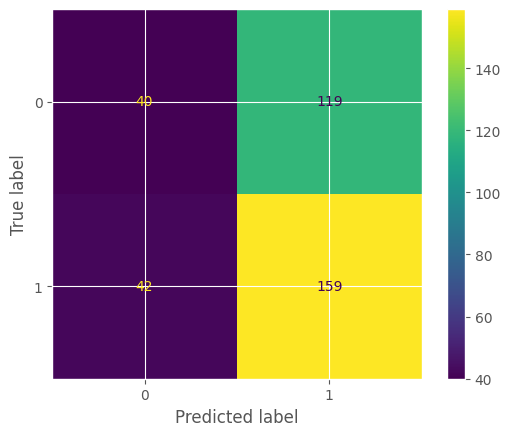

In [ ]:
confusion=mt.confusion_matrix(y_test,svc_pred)
mt.ConfusionMatrixDisplay(confusion).plot()

In [ ]:
auc=mt.roc_auc_score(y_test,svc_pred)

In [ ]:
auc

0.5213085515817141

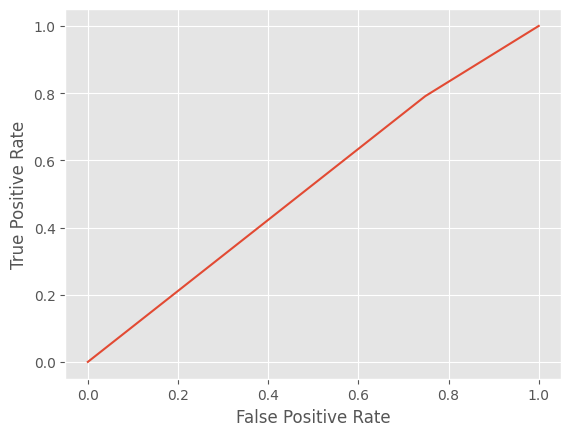

In [ ]:
fpr,tpr,thre=mt.roc_curve(y_test,svc_pred)

mt.RocCurveDisplay(fpr=fpr,tpr=tpr).plot()

In [ ]:
datos['Variación_ p'].value_counts()

 1    1006
-1     791
Name: Variación_ p, dtype: int64

### Tree

In [ ]:
arbol=DecisionTreeClassifier()
arbol.fit(x_train,y_train)

DecisionTreeClassifier()

In [ ]:
tree_pred=arbol.predict(x_test)

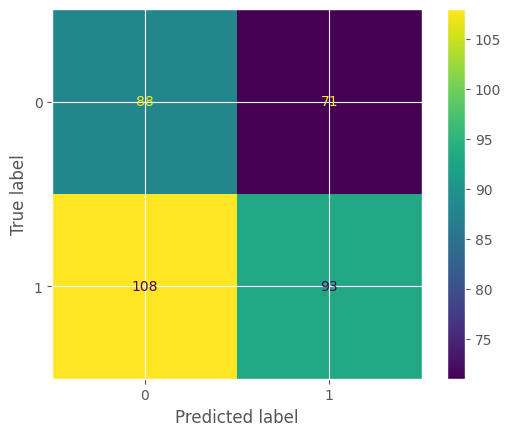

In [ ]:
confusion=mt.confusion_matrix(y_test,tree_pred)
mt.ConfusionMatrixDisplay(confusion).plot()

In [ ]:
print(mt.classification_report(y_test,tree_pred))

              precision    recall  f1-score   support

          -1       0.45      0.55      0.50       159
           1       0.57      0.46      0.51       201

    accuracy                           0.50       360
   macro avg       0.51      0.51      0.50       360
weighted avg       0.51      0.50      0.50       360



In [ ]:
fpr,tpr,thre=mt.roc_curve(y_test,tree_pred)
auc=mt.roc_auc_score(y_test,tree_pred)
auc

0.5080728433305173

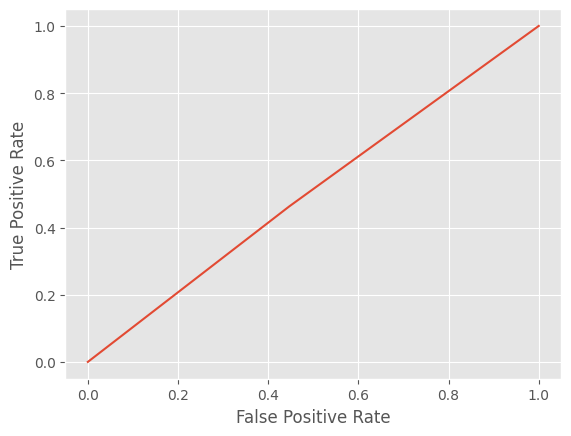

In [ ]:
fpr,tpr,thre=mt.roc_curve(y_test,tree_pred)

mt.RocCurveDisplay(fpr=fpr,tpr=tpr).plot()

### Random Forest

In [ ]:
bosque=RandomForestClassifier()
bosque.fit(x_train,y_train)

<ipython-input-415-a63fc6f5a745>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bosque.fit(x_train,y_train)


RandomForestClassifier()

In [ ]:
bosq_pred=bosque.predict(x_test)

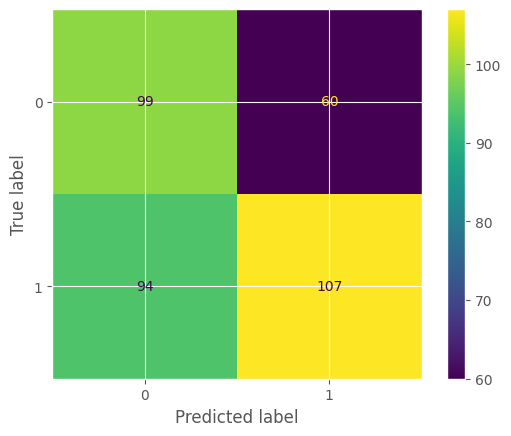

In [ ]:
confusion=mt.confusion_matrix(y_test,bosq_pred)
mt.ConfusionMatrixDisplay(confusion).plot()

In [ ]:
print(mt.classification_report(y_test,bosq_pred))

              precision    recall  f1-score   support

          -1       0.51      0.62      0.56       159
           1       0.64      0.53      0.58       201

    accuracy                           0.57       360
   macro avg       0.58      0.58      0.57       360
weighted avg       0.58      0.57      0.57       360



In [ ]:
mt.roc_auc_score(y_test,bosq_pred)

0.5774899089458368

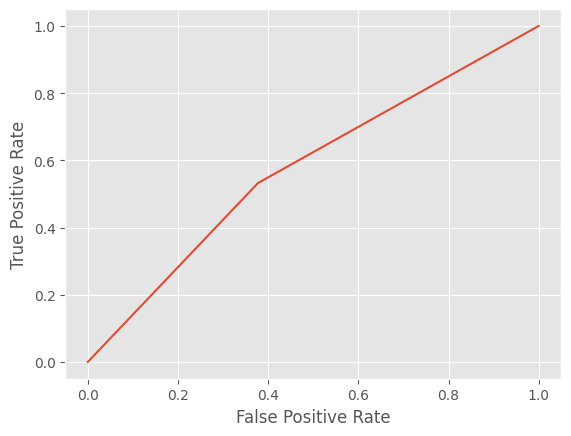

In [ ]:
fpr,tpr,thre=mt.roc_curve(y_test,bosq_pred)

mt.RocCurveDisplay(fpr=fpr,tpr=tpr).plot()

####Red neuronal

In [ ]:
red=MLPClassifier(hidden_layer_sizes=[64,32])#dos capas ocultas una de 64 nodos y otra de 32
red.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=[64, 32])

In [ ]:
red_predict=red.predict(x_test)

In [ ]:
print(mt.classification_report(y_test,red_predict))

              precision    recall  f1-score   support

          -1       0.46      0.61      0.52       159
           1       0.58      0.42      0.49       201

    accuracy                           0.51       360
   macro avg       0.52      0.52      0.51       360
weighted avg       0.52      0.51      0.50       360



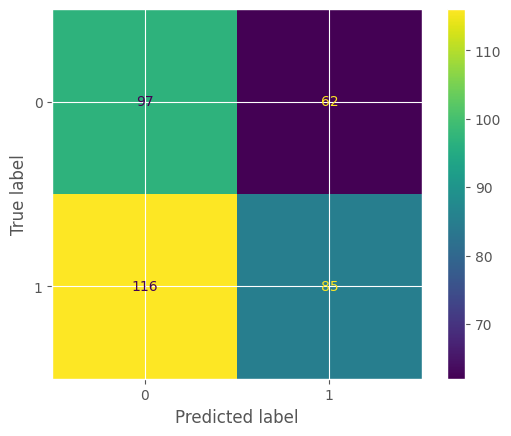

In [ ]:
confusion=mt.confusion_matrix(y_test,red_predict)
mt.ConfusionMatrixDisplay(confusion).plot()

In [ ]:
mt.roc_auc_score(y_test,red_predict)

0.5164742326105323

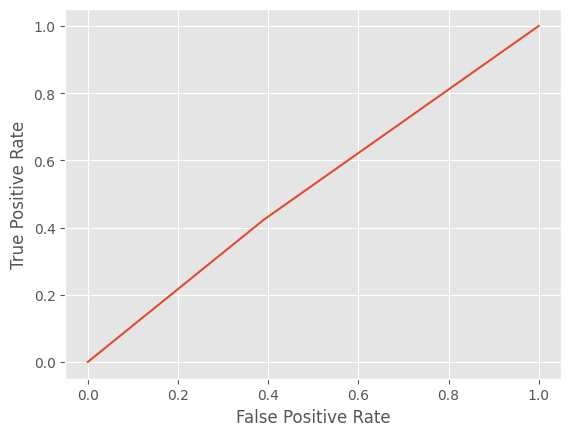

In [ ]:
fpr,tpr,thre=mt.roc_curve(y_test,red_predict)

mt.RocCurveDisplay(fpr=fpr,tpr=tpr).plot()

#Se evalua el modelo random forest ya que fue el de mejor rendimiento

In [ ]:
n=len(x_test)
df=datos.iloc[-n:,:].copy()

In [ ]:
df.index

DatetimeIndex(['2020-01-06 00:00:00+00:00', '2020-01-07 00:00:00+00:00',
               '2020-01-08 00:00:00+00:00', '2020-01-09 00:00:00+00:00',
               '2020-01-10 00:00:00+00:00', '2020-01-11 00:00:00+00:00',
               '2020-01-12 00:00:00+00:00', '2020-01-13 00:00:00+00:00',
               '2020-01-14 00:00:00+00:00', '2020-01-15 00:00:00+00:00',
               ...
               '2020-12-21 00:00:00+00:00', '2020-12-22 00:00:00+00:00',
               '2020-12-23 00:00:00+00:00', '2020-12-24 00:00:00+00:00',
               '2020-12-25 00:00:00+00:00', '2020-12-26 00:00:00+00:00',
               '2020-12-27 00:00:00+00:00', '2020-12-28 00:00:00+00:00',
               '2020-12-29 00:00:00+00:00', '2020-12-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=360, freq=None)

In [ ]:
df['Signal']=bosq_pred

In [ ]:
#backtesting
capital=[100]#suponemos que el dinero inicial son 100 doalres
TP=0.03#Take Profit
SL=0.01#Stop Loss
pos=0#la posicion inicla, al principio no hay ni corto ni largo
price=0
for i in range(1,n):
  capital.append(capital[i-1])#asi se agrega el nivel de capital del dia anterior, para calcula sobre ese el crecimiento
  if pos==1:#posición largo
    #alcanzar el take profit en una posición larga es que el precio subio por lo menos un 3% desde que se abrio en esa posicion
    #ganancia
    if df['Close'][i]>=price*(1+TP):#precio crecio mas o igual al 3% del momento en que abre la posición
      pos=0#se paasrá a no tener ninguna posición abierta
      capital[i]*=(1+TP)#capital crece 3%
   #perdida
    elif df['Close'][i]<=price*(1-SL):#precio disminuyo 1% o más del precio se compra
      pos=0
      capital[i]*=(1-SL)#el capital disminuye 1%

  elif pos==-1:#posición corto aca si el precio baja hay ganancia y si el precio sube hay perdida
    #ganancia
    if df['Close'][i]<=price*(1-TP):
      pos=0
      capital[i]*=(1+TP)
    #perdida
    elif df['Close'][i]>=price*(1+SL):
      pos=0
      capital[i]*=(1-SL)

  else:#sin posición
    if df['Signal'][i]!=0:
      pos=df['Signal'][i]#abre la posición
      price=df['Close'][i]

df['Capital']=capital

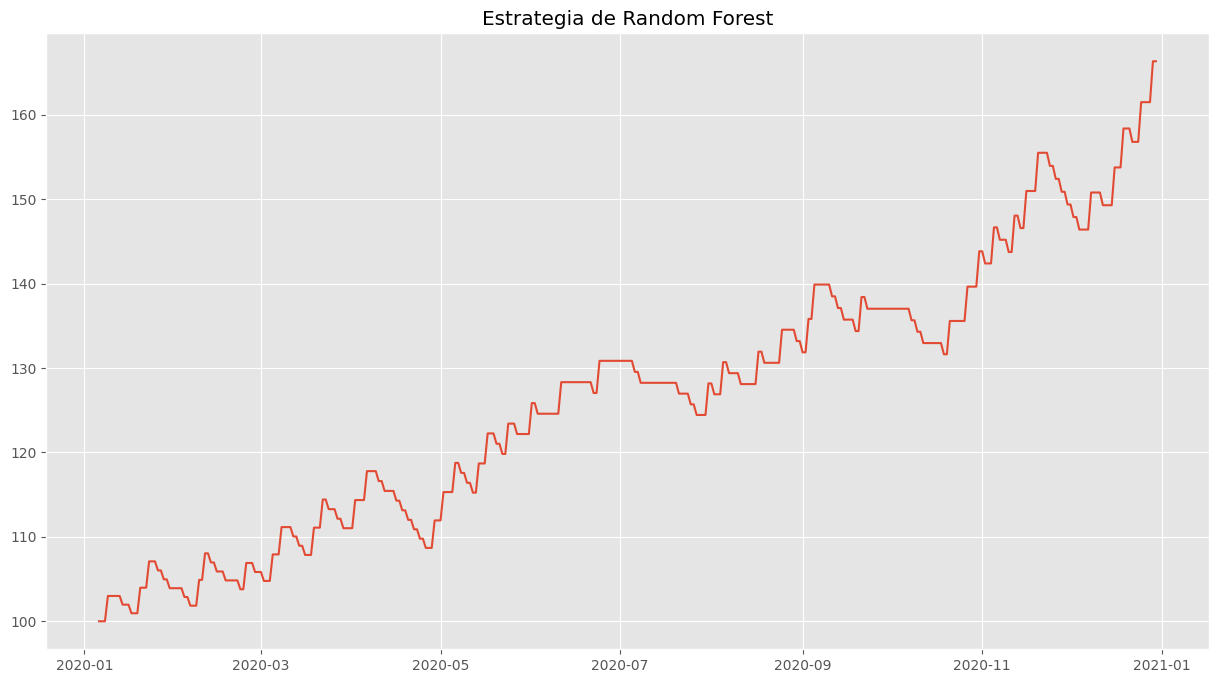

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Estrategia de Random Forest')
plt.plot(df['Capital'])
plt.show()

De aqui se obtiene que de 2020 a 2021 se hubiese pasado a obtener más de 170 dolares iniciando con un capital de 100 dolares

In [ ]:
#sharpe ratio, en nuna estrategia en largo
t_free=0.01
ret=np.log(df['Capital']).diff().mean()
ret=ret*252#rentabilidad anual
ret

0.35727815054108447

In [ ]:
#np.log(df['Capital']/df['Capital'].shift(1)).mean()*252

In [ ]:
vol=np.log(df['Capital']).diff().std()#desviación de rendimientos diaria
vol=vol*np.sqrt(252)#desviacion estandar anual
vol

0.16987276397775802

In [ ]:
sharpe_ratio=(ret-t_free)/vol
sharpe_ratio

2.044342732814748

In [ ]:
df2=yf.Ticker('^GSPC').history(start='2020-01-06',end='2020-12-30')

In [ ]:
df2['Capital']=(100/df2['Close'][0])*df2['Close']

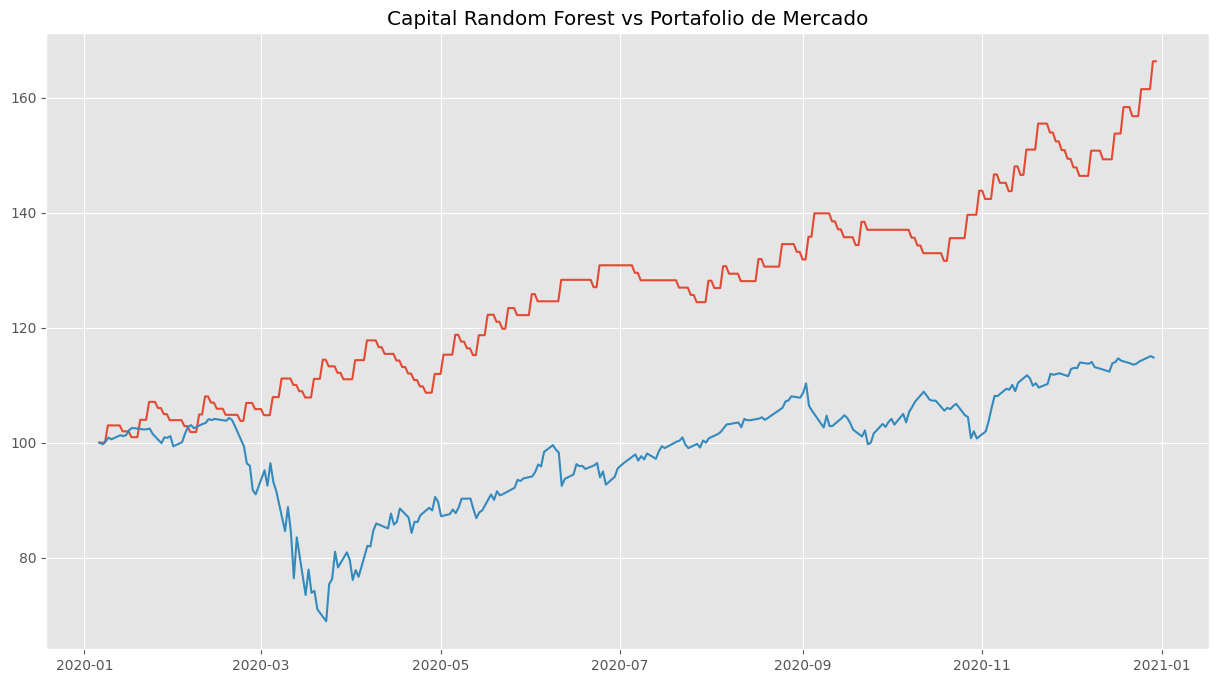

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Capital Random Forest vs Portafolio de Mercado')
plt.plot(df['Capital'])
plt.plot(df2['Capital'])
plt.show()

Se pasa de tener 100 dolares a un poco mas de 110 dolares

In [ ]:
#sharpe ratio,de portafolio de mercado
t_free=0.01
ret=np.log(df2['Capital']).diff().mean()
ret=ret*252#rentabilidad anual
ret

0.1403321230198806

In [ ]:
vol=np.log(df2['Capital']).diff().std()#desviación de rendimientos diaria
vol=vol*np.sqrt(252)#desviacion estandar anual
vol

0.35012751743343506

In [ ]:
sharpe_ratioM=(ret-t_free)/vol
sharpe_ratioM

0.3722418734044771

In [ ]:
sharpe_ratio,sharpe_ratioM

(2.044342732814748, 0.3722418734044771)

De acuerdo a lo anterior el exceso de retorno por cada unidad de riesgo tomando una estrategia de random forest es mayor que en el portafolio de mercado